In [16]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import sys

In [17]:
# GOAL: List of tickets in East Africa 1) opened and 2) closed 3) Pending
tickets = pd.read_csv('12thJune2023.csv',parse_dates = [2,7],dayfirst = True)
#link to the file: https://docs.google.com/spreadsheets/d/1rfkUNzggOgKZr-JOLBFCparb_rtscxN4qMIU5RoMqr4/edit#gid=0 
tickets.columns = tickets.columns.str.replace(' ','_')
#filter all year 2022 tickets
tickets_closed = tickets[tickets.Ticket_Closed_on > '2023-01-01']#tickets_closed_2022 = tickets_closed
tickets_opened = tickets[tickets.Issue_date > '2023-01-01']#tickets_closed_2021 = tickets_opened
#Africa Tickets



ea_countries = ['Kenya','Ghana','Uganda','Zambia','Chad','Rwanda','Mali','Burkina Faso','Tanzania','Nigeria','South Africa','Senegal','Madagascar','Benin', 'Zimbabwe','Congo','Ethiopia','Togo','Lesotho','Mozambique','Cameroon','Malawi','Niger','Ivory Coast']
# ea_countries =['Senegal','South Africa']
ea_opened = tickets_opened[tickets_opened.Country.isin (ea_countries)]#ea_opened_2021
ea_closed=  tickets_closed[(tickets_closed.Country.isin (ea_countries)) & (tickets_closed.Status == 'Closed')]#
ea_opened.head()


,Station_ID,Country,Issue_date,Assigned_to,Timeseries_variables,Ticket_link,Status,Ticket_Closed_on,Reopne_on,description_of_the_problem,Unnamed:_10,Remarks,Unnamed:_12,Unnamed:_13,Unnamed:_14,Unnamed:_15,Unnamed:_16,Unnamed:_17
0,TA00001,Kenya,2023-06-06,Victor,Offline,Sensor dx,Open,2021-07-12,6/6/2023,communication problem,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,TA00019,Kenya,2023-02-10,Victor,Precipitation,Sensor Dx,closed,2023-03-21,NaN,May be clogged,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,TA00041,Kenya,2023-05-16,Ghana Team,Offline,Sensor dx,Closed,2022-05-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131,TA00045,Ghana,2023-05-02,Ghana Team,Battery problem and data gaps,Sensor dx,Closed,2023-06-02,NaN,Battery problem and data gaps,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155,TA00057,Kenya,2023-04-04,Victor,Radiation,Sensor dx,Closed,2023-04-11,NaN,Solar radiation redords some errors,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# OPEN TICKETS
open_tickets = tickets[(tickets.Country.isin(ea_countries)) & (tickets.Status == "Open")]
# print(open_tickets)
# print(open_tickets)
c = open_tickets.groupby('Country').Station_ID.count()
c = c.reindex(ea_countries)
d = pd.DataFrame(c)
d = d.dropna(axis=0)
d.columns = ["Open Tickets"]
d = d.reindex(ea_countries)
d = d.fillna(0)
# add missing countries with 0 duration
for country in ea_countries:
    if country not in d.index:
        d.loc[country] = [0] * (len(d.columns)-1)
# d = d.sort_index()
d.loc["Africa"] = d.sum(numeric_only=True) # add a row and populate


# AVERAGE TIME TO CLOSE THE TICKET
duration = []
counter = []
for i in ea_countries:  
    country = open_tickets[open_tickets.Country == i]
    counter.append(i)
    country_duration = pd.to_datetime("today") - country['Issue_date']
    if len(country_duration) > 0:
        average = country_duration.sum()/len(country_duration)
    else:
        average = pd.Timedelta('0 days')
        
    duration.append(average)
duration = ([d.days for d in duration])
duration.append(sum(duration)/len(duration))
duration[-1] = int(duration[-1])
duration = [int(np.nan_to_num(i, nan=0)) for i in duration]
d.loc['Africa'] = [0] * len(d.columns)
d.loc["Africa"] = d.sum(numeric_only=True) # add a row and populate
# print(len(duration))
# print(duration)
# print(len(d.index))
# print(d.index)
d['Days Open (average)'] = duration
# print(d)
# PENDING TICKETS
counter = []
pending_tickets = tickets[(tickets.Country.isin(ea_countries)) & (tickets.Status == "Pending")]
for i in ea_countries:
    counter.append(pending_tickets[pending_tickets.Country == i].Country.count())
counter.append(sum(counter))
d['Pending Tickets'] = counter

# NUMBER OF STATIONS
stations = pd.read_csv('https://datahub.tahmo.org/custom/stations/status?output=csv')
inactive_stations = stations[stations['active'] == False]
non_aws = stations[~stations['id'].str.contains('TA')]
active_stations = stations[~stations.id.isin(inactive_stations.id.tolist())]
active_stations = active_stations[active_stations['id'].str.contains('TA')]

# Define the East African countries and their country codes
ea_countries = ['Kenya', 'Ghana', 'Uganda', 'Zambia', 'Chad', 'Rwanda', 'Mali', 'Burkina Faso', 'Tanzania', 'Nigeria', 'South Africa', 'Senegal', 'Madagascar', 'Benin', 'Zimbabwe', 'Congo', 'Ethiopia', 'Togo', 'Lesotho', 'Mozambique', 'Cameroon', 'Malawi', 'Niger', 'Ivory Coast']
ea_codes = ['KE', 'GH', 'UG', 'ZM', 'TD', 'RW', 'ML', 'BF', 'TZ', 'NG', 'ZA', 'SN', 'MG', 'BJ', 'ZW', 'CD', 'ET', 'TG', 'LS', 'MZ', 'CM', 'MW', 'NE', 'CI']

counter = []
for i in ea_codes:
    stations_no = active_stations[active_stations.country_code == i].name.count()
    counter.append(stations_no)
counter.append(sum(counter))
d['Stations'] = counter

# REORDER THE COLUMNS
d = d.iloc[:, [3,0,1,2]]

# PERCENTAGE OK
pc_ok = round((d.Stations-(d["Open Tickets"] + d['Pending Tickets']))/d.Stations*100, 2)
d['% OK'] = pc_ok
d

,Stations,Open Tickets,Days Open (average),Pending Tickets,% OK
Country,,,,,
Kenya,132,20.0,188,4,81.82
Ghana,99,30.0,460,8,61.62
Uganda,55,15.0,194,1,70.91
Zambia,20,18.0,795,0,10.00
Chad,6,6.0,797,0,0.00
Rwanda,17,7.0,274,0,58.82
Mali,44,35.0,450,1,18.18
Burkina Faso,18,3.0,319,0,83.33
Tanzania,34,10.0,153,1,67.65


In [19]:
#WEEKLY TICKET REVIEW  - TIMELINE TICKETS

from datetime import datetime

today = pd.to_datetime("today").strftime("%Y-%m-%d")
#Change the start and stop date on the next 2 lines of code to reflect the duration under review

#***********************

start_date = '2023-06-02'
stop_date = '2023-06-12'

#***********************

start_date = datetime.strptime(start_date, '%Y-%m-%d')
stop_date = datetime.strptime(stop_date, '%Y-%m-%d')

# today = pd.to_datetime("today").strftime("%Y-%m-%d")
# stop_date = today

tickets_closed = tickets[(tickets.Ticket_Closed_on > start_date) & (tickets.Ticket_Closed_on <= stop_date)]#tickets_closed_2022 = tickets_closed
tickets_opened = tickets[(tickets.Issue_date > start_date) & (tickets.Issue_date <= stop_date)]#tickets_closed_2021 = tickets_opened


countries = ['Kenya','Ghana','Uganda','Zambia','Chad','Rwanda','Mali','Burkina Faso','Tanzania','Nigeria','South Africa','Senegal','Madagascar','Benin', 'Zimbabwe','Congo','Ethiopia','Togo','Lesotho','Mozambique','Cameroon','Malawi','Niger','Ivory Coast','AFRICA']
closed = []
opened = []
for i in ea_countries: 
    closed.append(tickets_closed[tickets_closed.Country == i].Country.count())
    opened.append(tickets_opened[tickets_opened.Country == i].Country.count())
   # opened.append(tickets_opened[tickets_opened.Country == i])
closed.append(sum(closed))
opened.append(sum(opened))          
e = pd.DataFrame()
e['Country'] = countries
e = e.set_index('Country')
e['Ticket Closed'] = closed
e['Tickets Opened'] = opened
e

,Ticket Closed,Tickets Opened
Country,,
Kenya,3,4
Ghana,7,0
Uganda,1,0
Zambia,0,0
Chad,0,0
Rwanda,0,0
Mali,0,0
Burkina Faso,0,0
Tanzania,0,0


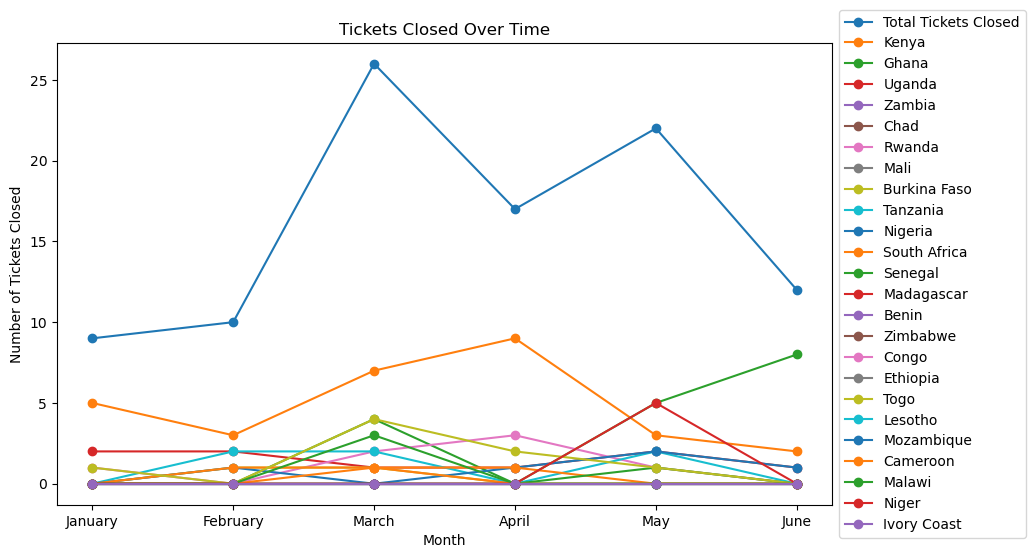

,Total Tickets Closed,Kenya,Ghana,Uganda,Zambia,Chad,Rwanda,Mali,Burkina Faso,Tanzania,...,Zimbabwe,Congo,Ethiopia,Togo,Lesotho,Mozambique,Cameroon,Malawi,Niger,Ivory Coast
Month,,,,,,,,,,,,,,,,,,,,,
January,9,5,0,2,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
February,10,3,0,2,0,0,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
March,26,7,4,1,0,0,2,0,1,2,...,0,0,0,4,0,0,1,3,0,0
April,17,9,0,1,0,0,3,0,0,0,...,0,0,0,2,0,0,0,0,0,0
May,22,3,5,2,0,0,1,0,0,2,...,0,0,0,1,0,0,0,0,5,0
June,12,2,8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Total,97,56,26,10,0,0,14,0,4,12,...,0,0,0,16,0,0,2,6,10,0


In [20]:
# #TIME SERIES GRAPH: Tickets Closed

# df = ea_closed
# # print(df)
# df = df.set_index('Ticket_Closed_on')
# monthly = df.groupby(pd.Grouper(freq='M')).size()
# monthly.index = monthly.index.month_name()
# monthly['Total'] = sum(monthly)
# table = pd.DataFrame(monthly)
# table.columns = ['Total Tickets Closed']
# table.index.names = ['Month']

# #tickets Closed
# ## Creating a table for each country
# for country in ea_countries: # looping over every country. 
    
#     country_dataset = ea_closed[ea_closed.Country == country]
#     df = country_dataset
#     df = df.set_index('Ticket_Closed_on')
#     monthly = df.groupby(pd.Grouper(freq='M')).size()
#     monthly.index = monthly.index.month_name()
#     monthly['Total'] = sum(monthly)
#     t = pd.DataFrame(monthly)
#     #t.columns = [country]
#     #t.index.names = ['Month']
#     table[country] = t
# closed_series = (table.fillna(0)).astype('int')# 0 all NA and convert all numbers to integer
# pd.set_option('display.max_columns', 30)
# closed_series

# ChatGPTVersion

# # closed_series
# import pandas as pd
# import matplotlib.pyplot as plt
# import datetime

# df = ea_closed
# df['Ticket_Closed_on'] = pd.to_datetime(df['Ticket_Closed_on'])  # Convert to datetime format
# df = df.set_index('Ticket_Closed_on')

# # Total tickets closed
# monthly_total = df.groupby(pd.Grouper(freq='M')).size()
# monthly_total.index = monthly_total.index.month_name()
# total_tickets_closed = monthly_total.sum()

# # Tickets closed by country
# table = pd.DataFrame(monthly_total, columns=['Total Tickets Closed'])
# table.index.names = ['Month']

# current_month = datetime.datetime.now().month
# current_year = datetime.datetime.now().year

# for country in ea_countries:
#     country_dataset = df[df.Country == country]  # Select data for the specific country
#     country_monthly = country_dataset.groupby(pd.Grouper(freq='M')).size()
#     country_monthly.index = country_monthly.index.month_name()
#     table[country] = country_monthly

# closed_series = table.fillna(0).astype(int)

# # Create 'date' column with first day of each month
# closed_series['date'] = pd.to_datetime(closed_series.index + ' 1, ' + str(current_year), format="%B %d, %Y")
# start_month = pd.to_datetime("January 2023", format="%B %Y")
# end_month = pd.to_datetime(datetime.datetime.now().strftime("%B %Y"), format="%B %Y")

# # Filter months from January 2023 to current month
# closed_series = closed_series.loc[
#     (closed_series['date'] >= start_month) &
#     (closed_series['date'] <= end_month)
# ]

# closed_series = closed_series.drop(columns='date')

# # Add row for total tickets closed
# closed_series.loc['Total'] = closed_series.sum()

# # Plotting the time series graph
# ax = closed_series[:-1].plot(kind='line', marker='o', figsize=(10, 6))
# ax.set_xlabel('Month')
# ax.set_ylabel('Number of Tickets Closed')
# ax.set_title('Tickets Closed Over Time')
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# plt.show()

# # Display the table
# closed_series
import pandas as pd
import matplotlib.pyplot as plt
import datetime

df = ea_closed
df['Ticket_Closed_on'] = pd.to_datetime(df['Ticket_Closed_on'])  # Convert to datetime format
df = df.set_index('Ticket_Closed_on')

# Total tickets closed
monthly_total = df.groupby(pd.Grouper(freq='M')).size()
monthly_total.index = monthly_total.index.month_name()
total_tickets_closed = monthly_total.sum()

# Tickets closed by country
table = pd.DataFrame(monthly_total, columns=['Total Tickets Closed'])
table.index.names = ['Month']

current_month = datetime.datetime.now().month
current_year = datetime.datetime.now().year

for country in ea_countries:
    country_dataset = df[df.Country == country]  # Select data for the specific country
    country_monthly = country_dataset.groupby(pd.Grouper(freq='M')).size()
    country_monthly.index = country_monthly.index.month_name()
    table[country] = country_monthly

closed_series = table.fillna(0).astype(int)

# Create 'date' column with first day of each month
closed_series['date'] = pd.to_datetime(closed_series.index + ' 1, ' + str(current_year), format="%B %d, %Y")
start_month = pd.to_datetime("January 2023", format="%B %Y")
end_month = pd.to_datetime(datetime.datetime.now().strftime("%B %Y"), format="%B %Y")

# Filter months from January 2023 to current month
closed_series = closed_series.loc[
    (closed_series['date'] >= start_month) &
    (closed_series['date'] <= end_month)
]

closed_series = closed_series.drop(columns='date')

# Add row for total tickets closed
closed_series.loc['Total'] = closed_series.sum()

# Remove duplicated months
closed_series = closed_series[~closed_series.index.duplicated(keep='first')]

# Plotting the time series graph
ax = closed_series[:-1].plot(kind='line', marker='o', figsize=(10, 6))
ax.set_xlabel('Month')
ax.set_ylabel('Number of Tickets Closed')
ax.set_title('Tickets Closed Over Time')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

# Display the table
closed_series


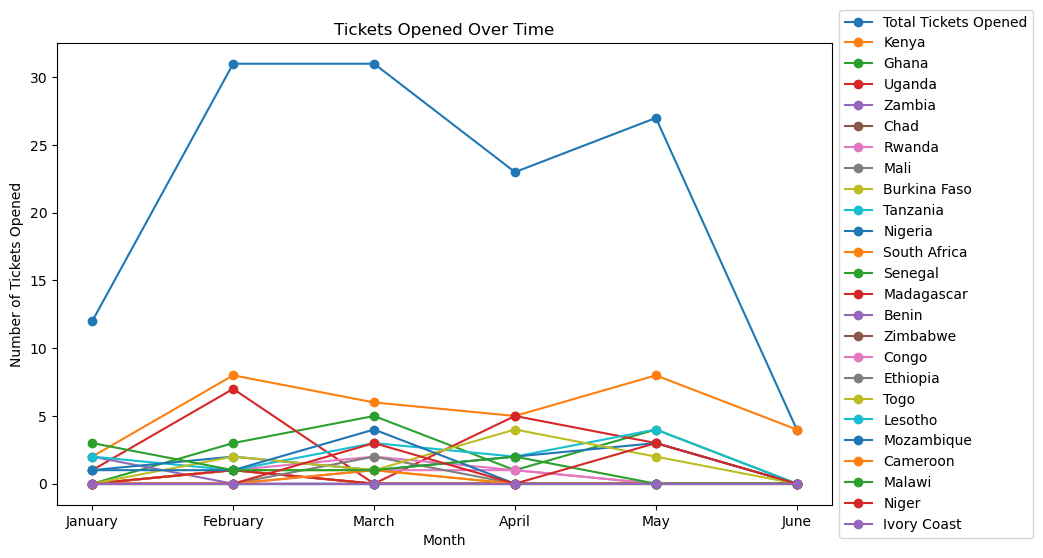

,Total Tickets Opened,Kenya,Ghana,Uganda,Zambia,Chad,Rwanda,Mali,Burkina Faso,Tanzania,...,Zimbabwe,Congo,Ethiopia,Togo,Lesotho,Mozambique,Cameroon,Malawi,Niger,Ivory Coast
Month,,,,,,,,,,,,,,,,,,,,,
January,12,2,0,1,2,0,0,0,0,2,...,0,0,0,0,0,1,0,3,0,0
February,31,8,3,7,0,1,1,1,1,1,...,0,0,0,2,0,1,0,1,0,0
March,31,6,5,0,0,0,2,0,1,3,...,0,1,2,1,0,4,1,1,3,0
April,23,5,1,5,0,0,1,0,0,2,...,0,1,0,4,0,0,0,2,0,0
May,27,8,4,3,0,0,0,0,0,4,...,0,0,0,2,0,0,0,0,3,0
June,4,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Total,128,33,13,16,2,1,4,1,2,12,...,0,2,2,9,0,6,1,7,6,0


In [15]:
# #TIME SERIES GRAPH: Tickets Opened by MONTH

# df = ea_opened
# # print(df)
# df = df.set_index('Issue_date')
# monthly = df.groupby(pd.Grouper(freq='M')).size()
# monthly.index = monthly.index.month_name()
# monthly['Total'] = sum(monthly)# sum of row
# table = pd.DataFrame(monthly)
# table.columns = ['Total Tickets opened']
# table.index.names = ['Month']

# for country in ea_countries: 
#     country_dataset = ea_opened[ea_opened.Country == country]
#     df = country_dataset
#     df = df.set_index('Issue_date')
#     monthly = df.groupby(pd.Grouper(freq='M')).size()
#     monthly.index = monthly.index.month_name()
#     monthly['Total'] = sum(monthly)
#     t = pd.DataFrame(monthly)
#     #t.columns = [country]
#     #t.index.names = ['Month']
#     table[country] = t
# x = table.fillna(0)
# open_series = x.astype('int')# converts the entire dataframe to integer
# open_series

#ChatGPTVersion

# TIME SERIES GRAPH: Tickets Opened by MONTH
df = ea_opened
df = df.set_index('Issue_date')
monthly = df.groupby(pd.Grouper(freq='M')).size()
monthly.index = monthly.index.month_name()
monthly['Total'] = monthly.sum()  # Total tickets opened
table = pd.DataFrame(monthly)
table.columns = ['Total Tickets Opened']
table.index.names = ['Month']

for country in ea_countries:
    country_dataset = ea_opened[ea_opened.Country == country]
    df = country_dataset
    df = df.set_index('Issue_date')
    monthly = df.groupby(pd.Grouper(freq='M')).size()
    monthly.index = monthly.index.month_name()
    monthly['Total'] = monthly.sum()
    t = pd.DataFrame(monthly)
    table[country] = t

open_series = table.fillna(0).astype(int)

# Remove duplicated months
open_series = open_series[~open_series.index.duplicated(keep='first')]

# Plotting the time series graph
ax = open_series[:-1].plot(kind='line', marker='o', figsize=(10, 6))
ax.set_xlabel('Month')
ax.set_ylabel('Number of Tickets Opened')
ax.set_title('Tickets Opened Over Time')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

# Display the table
open_series



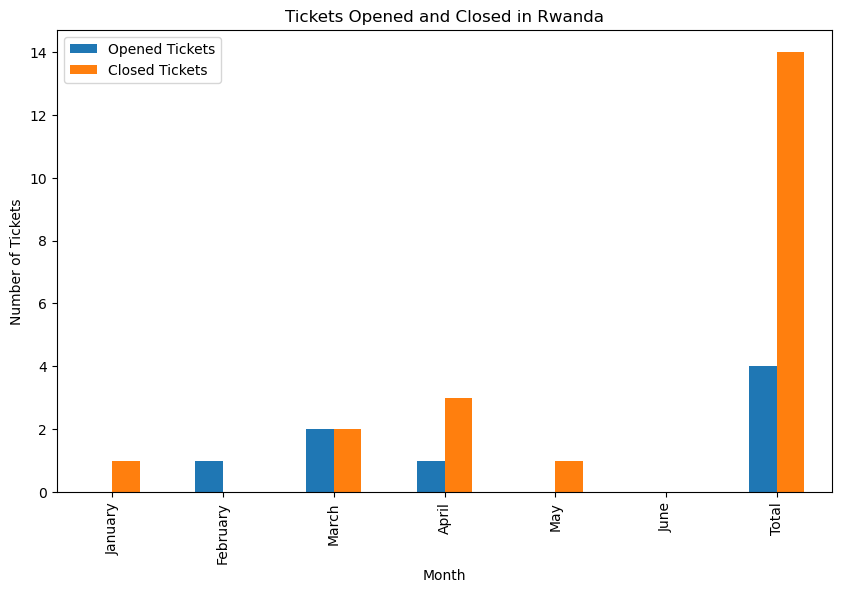

,Opened Tickets,Closed Tickets
Month,,
January,0,1
February,1,0
March,2,2
April,1,3
May,0,1
June,0,0
Total,4,14


In [21]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# i = "Kenya"
# x = pd.DataFrame()
# x["Opened Tickets"] = open_series[i]
# x["Closed Tickets"] = closed_series[i]
# x
import matplotlib.pyplot as plt
%matplotlib inline

# Create a DataFrame with opened and closed tickets for a specific country
i = "Rwanda"
x = pd.DataFrame()
x["Opened Tickets"] = open_series[i]
x["Closed Tickets"] = closed_series[i]

# Plot the data as a bar graph
x.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Month')
plt.ylabel('Number of Tickets')
plt.title(f'Tickets Opened and Closed in {i}')
plt.legend()
plt.show()

# Display the DataFrame
x



Text(0.5, 1.0, 'Africa: Monthly Tickets')

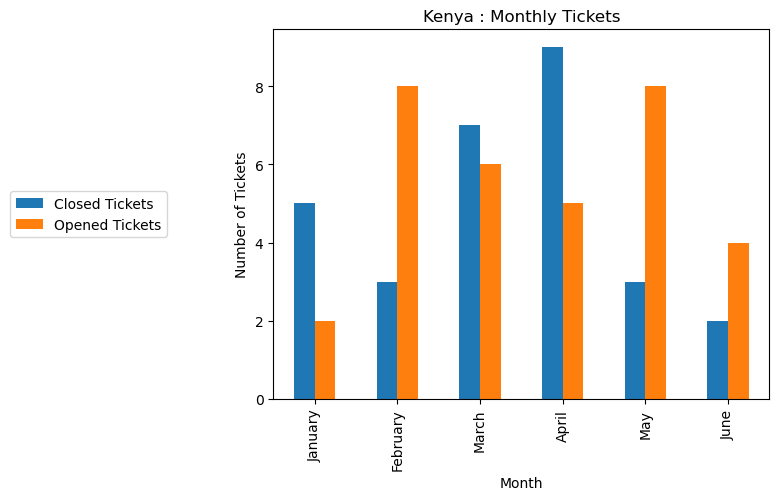

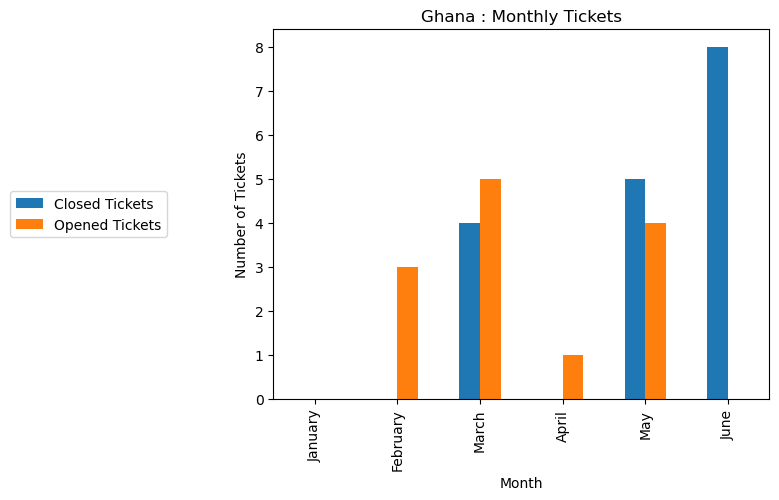

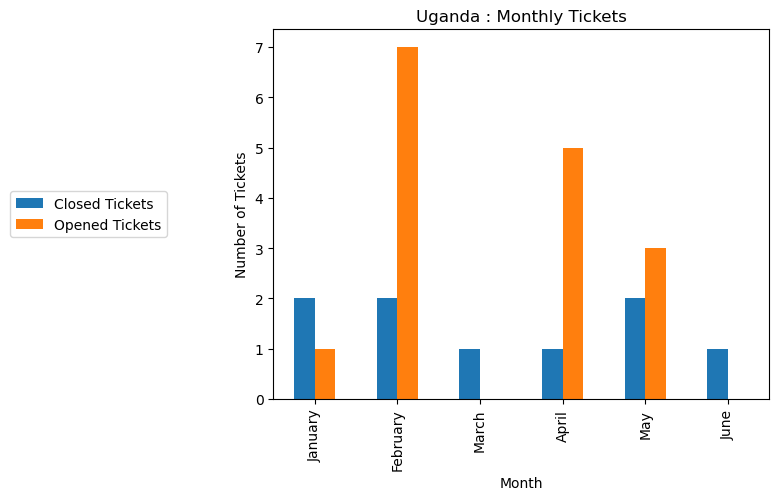

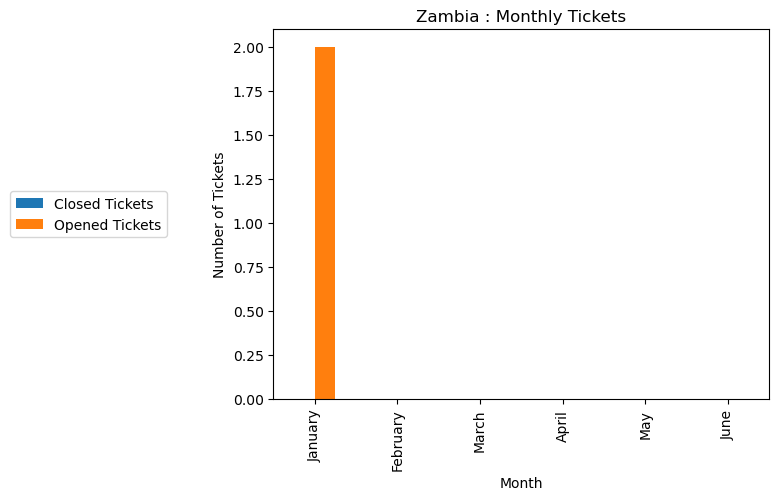

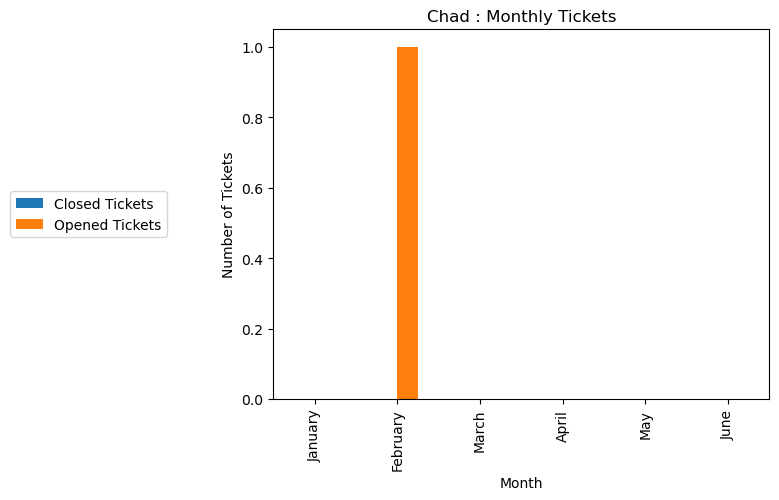

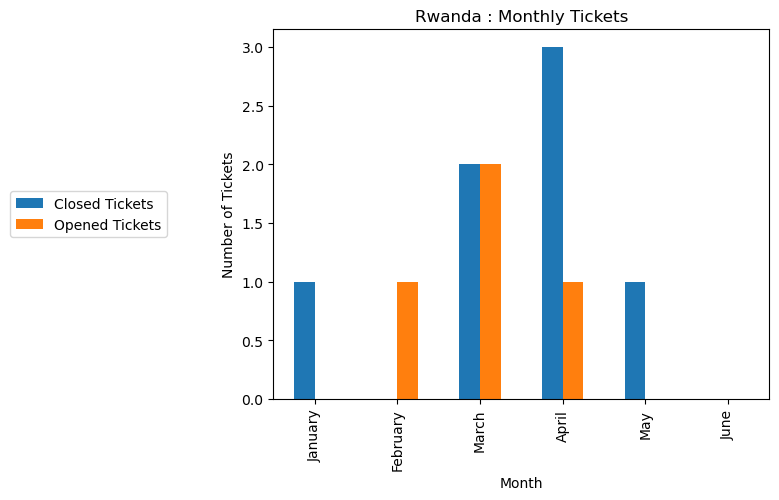

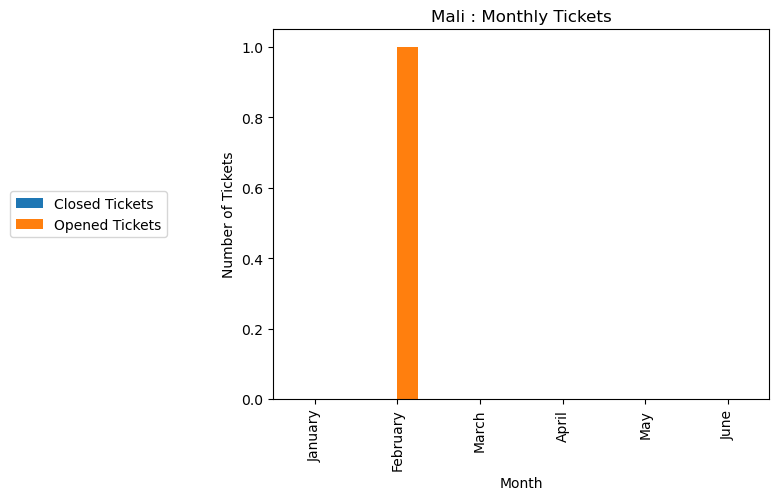

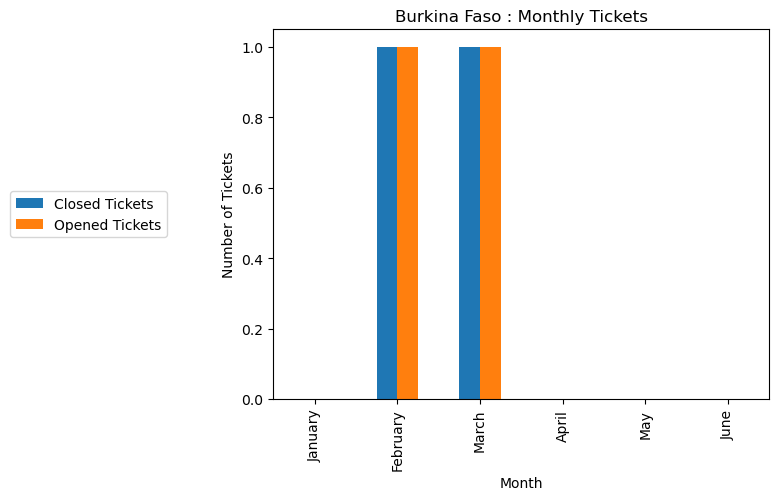

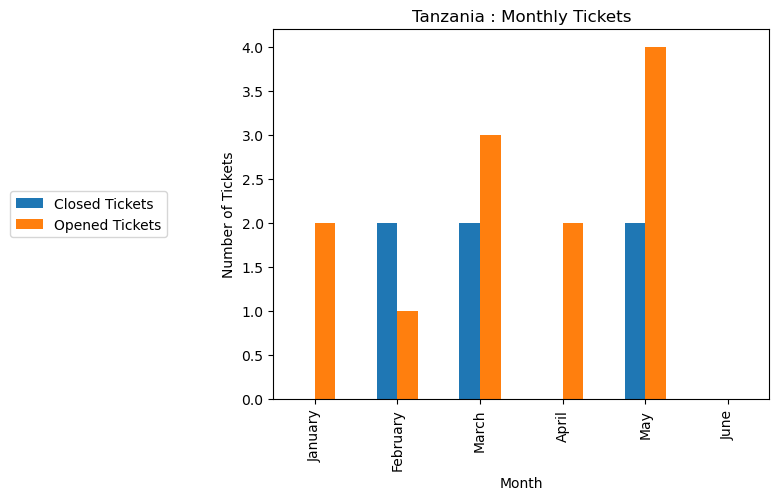

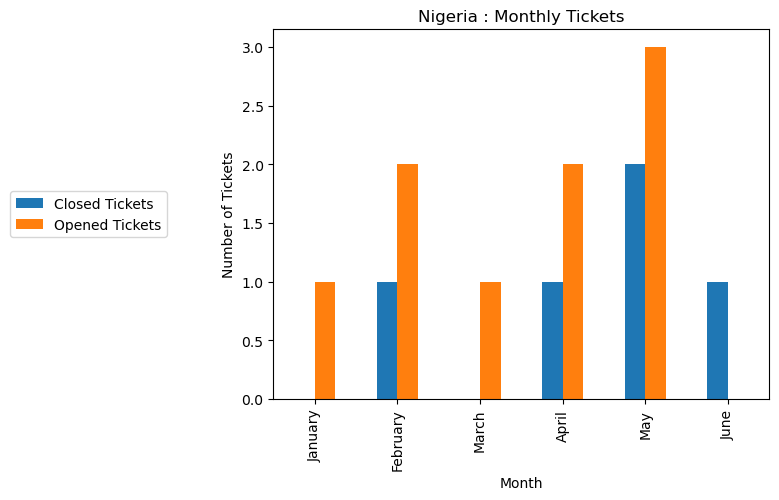

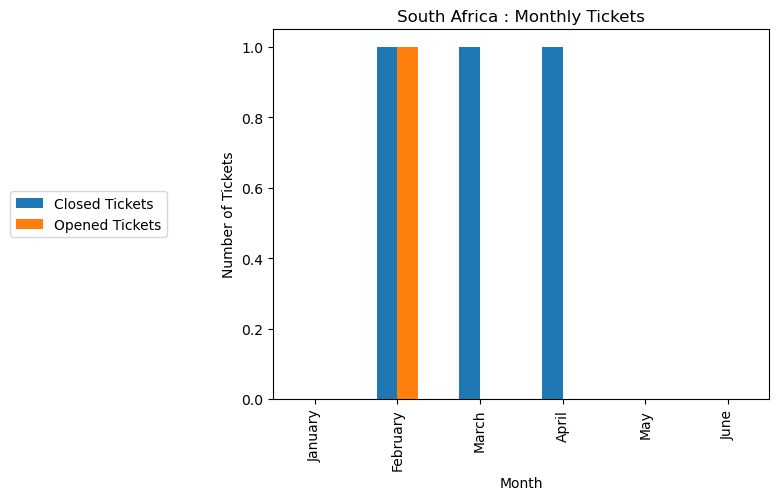

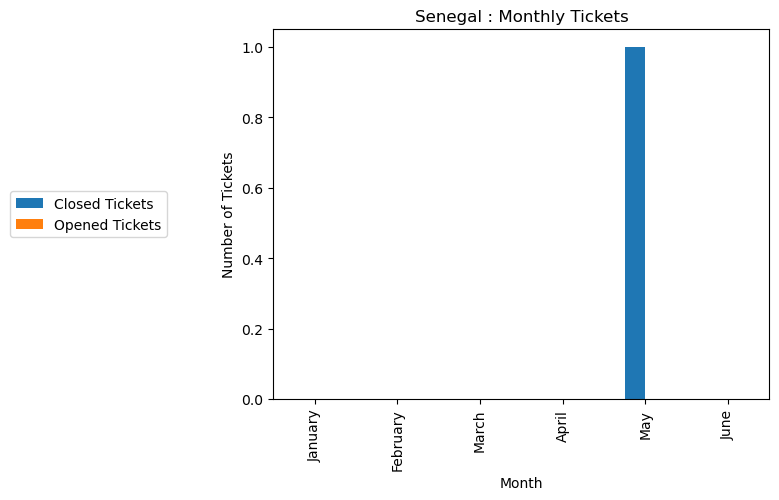

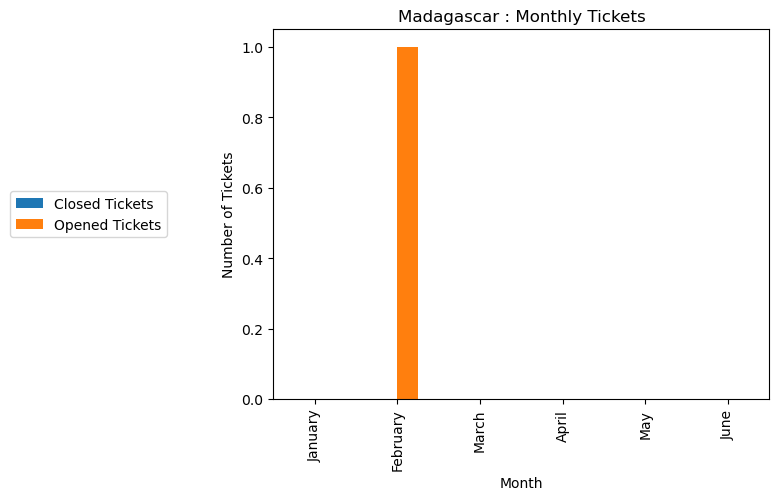

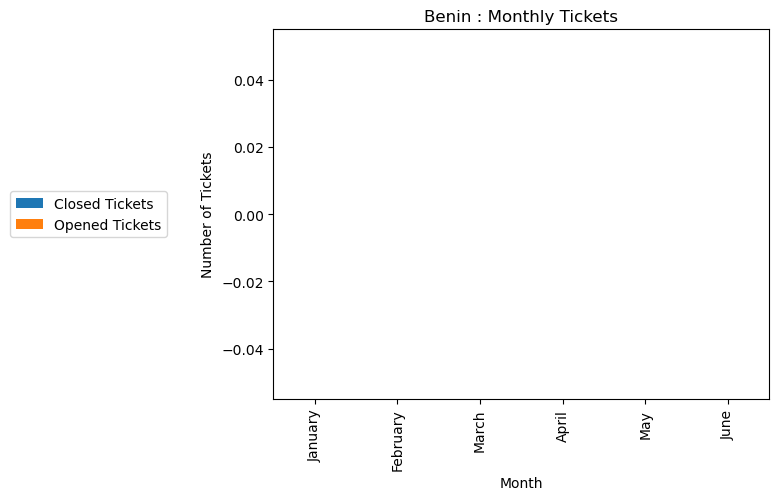

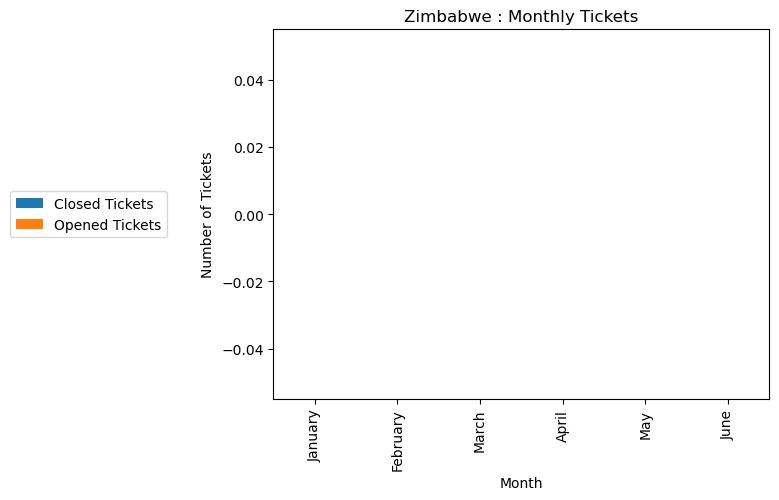

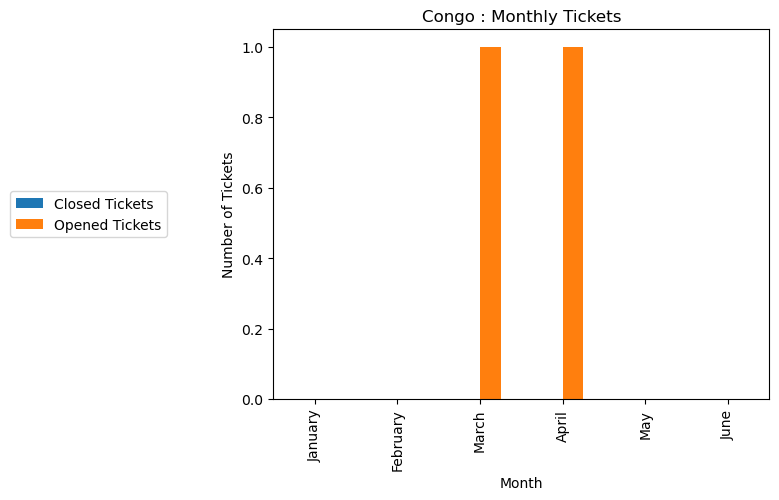

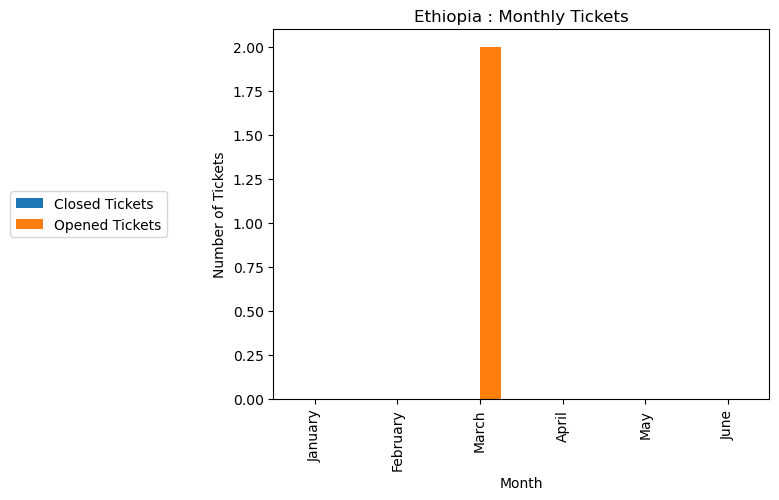

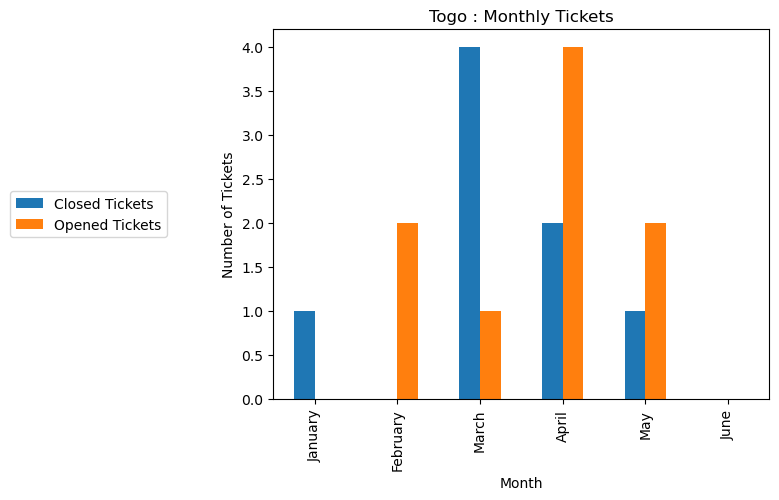

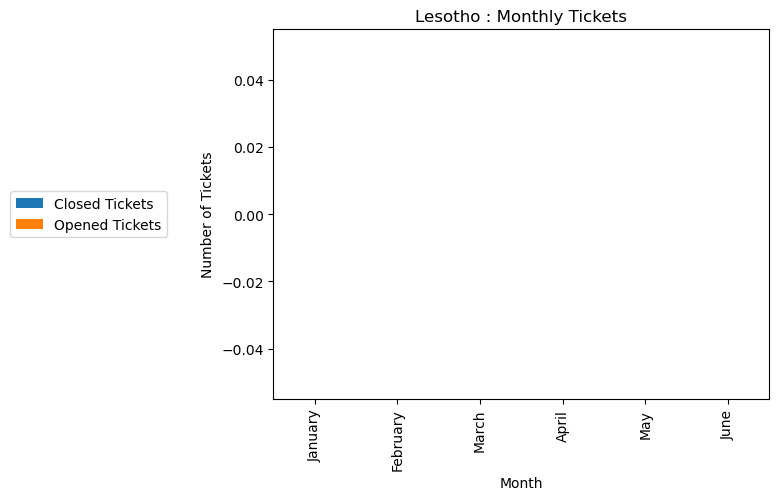

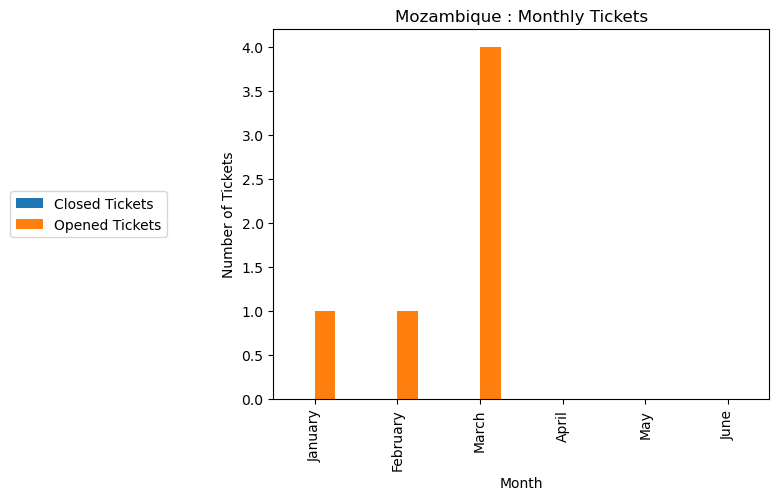

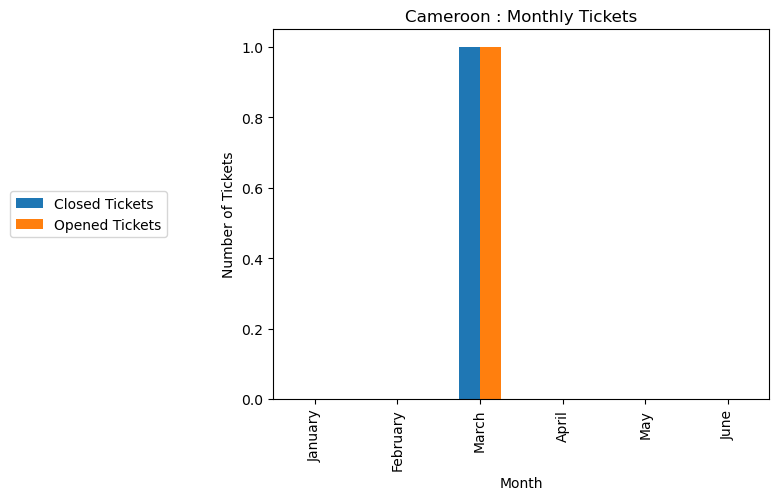

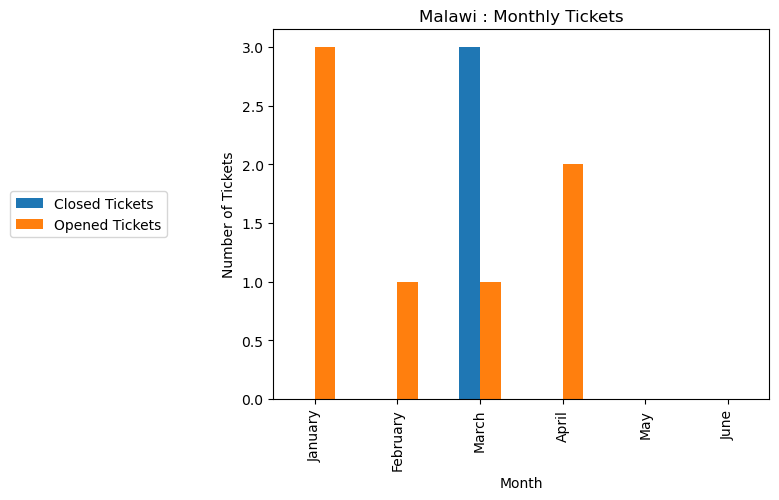

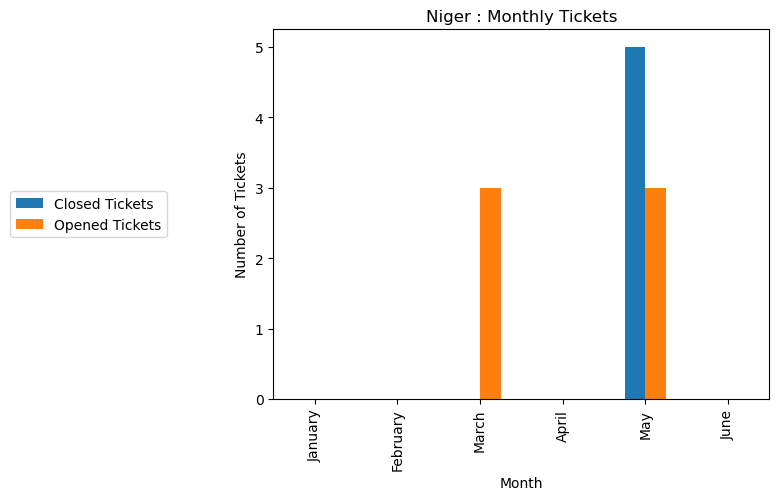

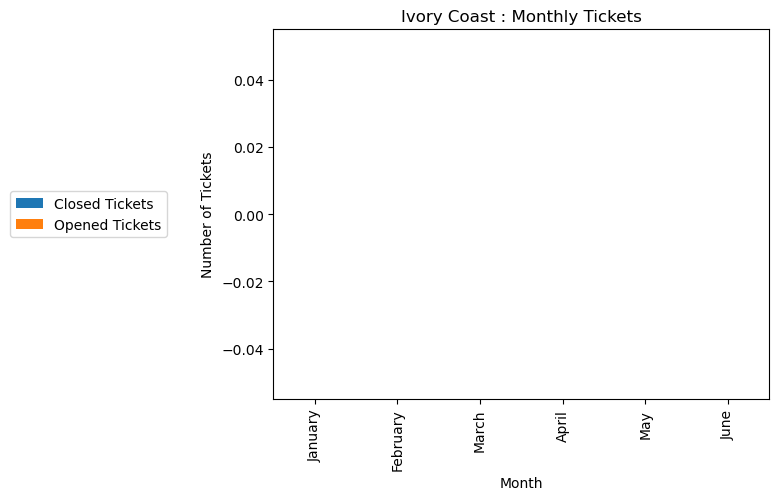

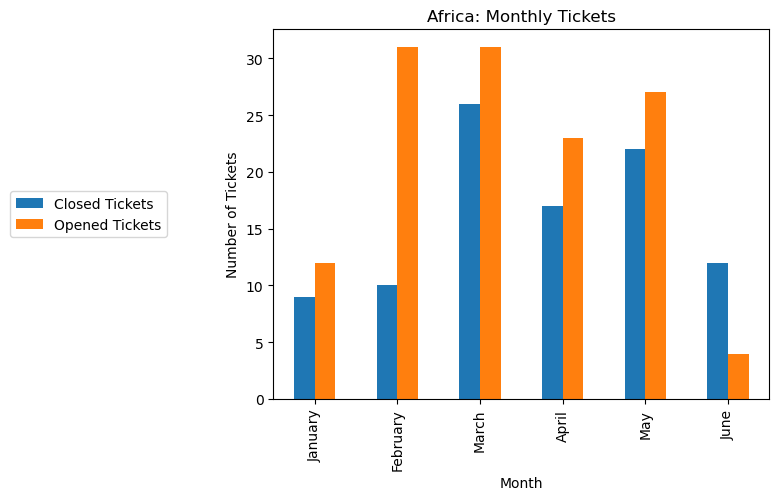

In [13]:
# PLOT 1: Closed tickets vs Opened Tickets, By COUNTRY
# We pull data from open_series ( dataframe of open tickets) and closed_series( dataframe of closed tickets)
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['figure.max_open_warning'] = 50
%matplotlib inline

for i in ea_countries:
    x = pd.DataFrame()
    
    x["Closed Tickets"] = closed_series[i]
    x["Opened Tickets"] = open_series[i]
   
    
    x = x.drop("Total") 
    
    
    plt = x.plot.bar()
    plt.legend(loc = 'right',bbox_to_anchor = (-0.2,0.5))
    plt.set_ylabel('Number of Tickets')
    plt.set_title(f"{i} : Monthly Tickets")

# Totals for East Africa
x = pd.DataFrame()
##**** CHECK TO ENSURE ALL MONTHS ARE LISTED WITHOUT HAVING TO INTERCHANGE THE NEXT TWO LINES


x["Closed Tickets"] = closed_series.iloc[:,0]
x["Opened Tickets"] = open_series.iloc[:,0]


x = x.drop("Total")
plt = x.plot.bar()
plt.legend(loc = 'right',bbox_to_anchor = (-0.2,0.5))
plt.set_ylabel('Number of Tickets')
plt.set_title("Africa: Monthly Tickets")

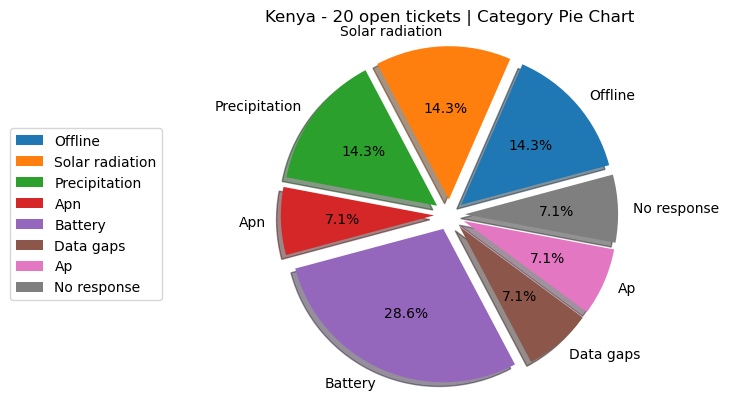

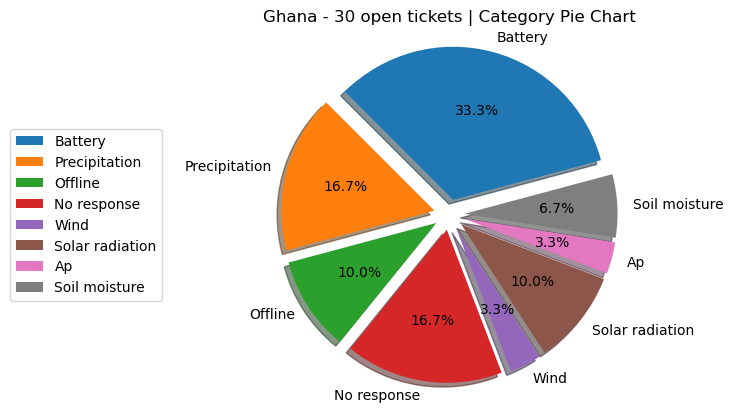

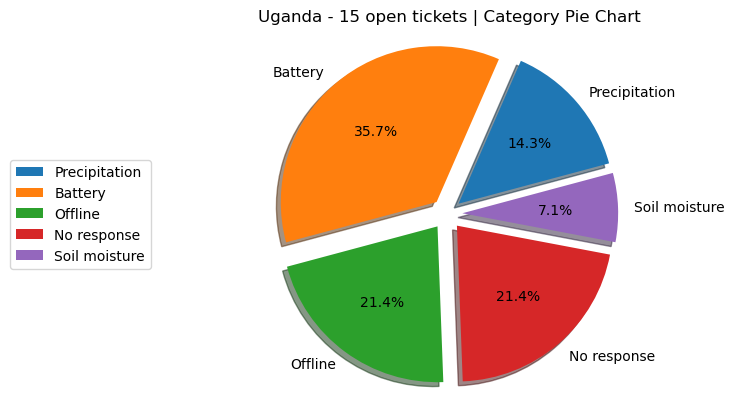

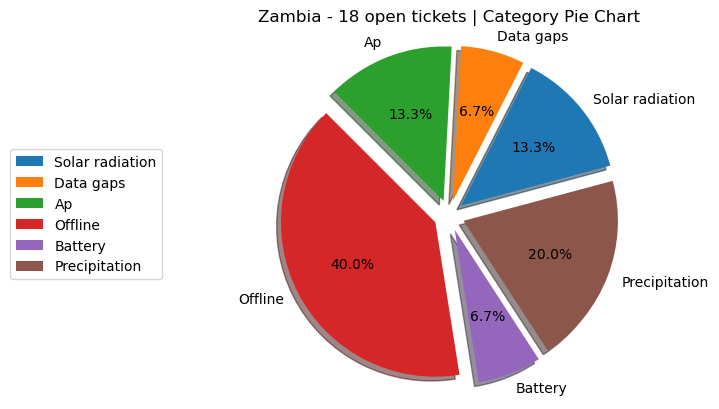

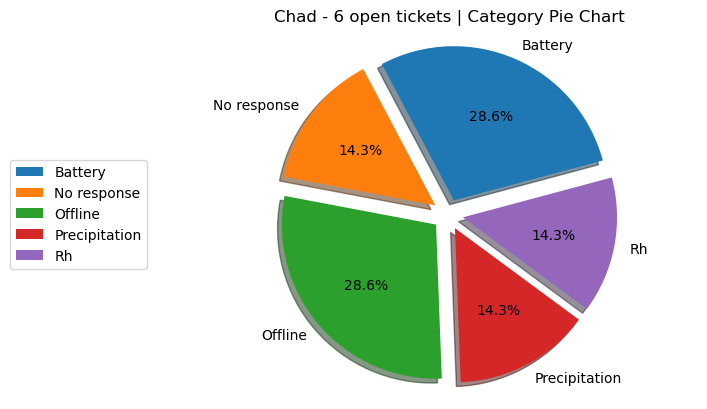

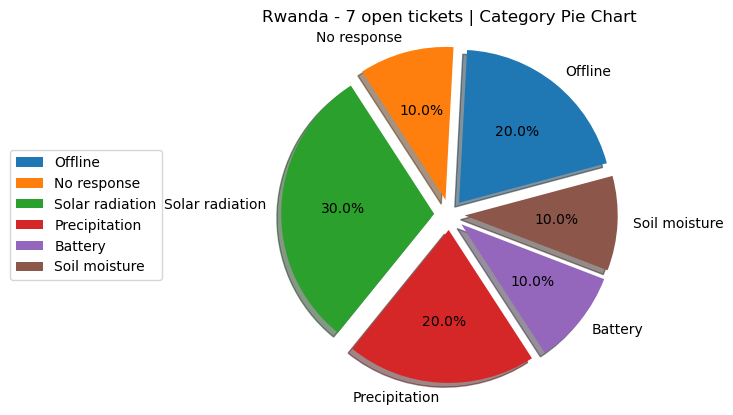

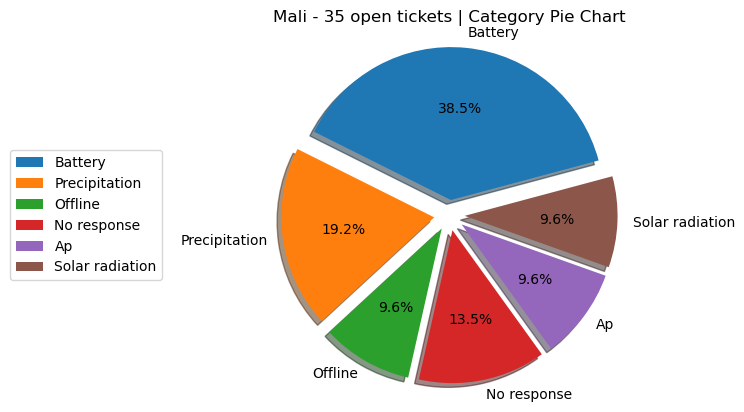

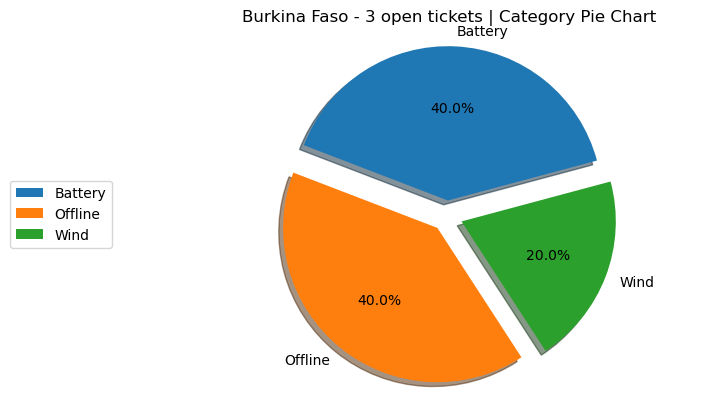

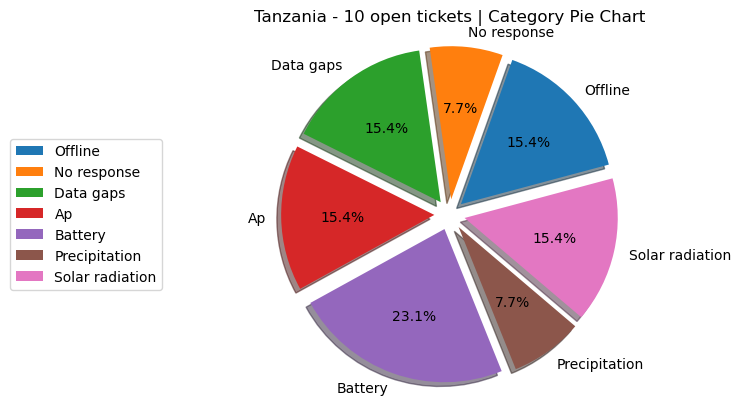

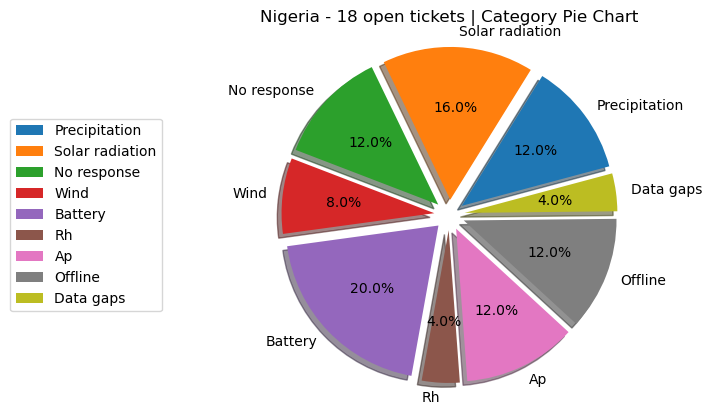

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


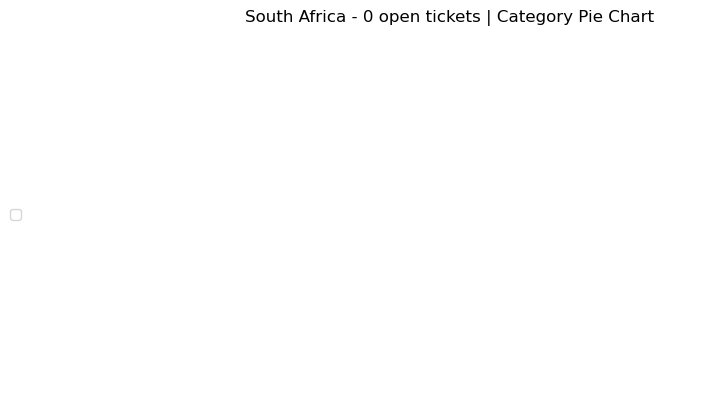

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


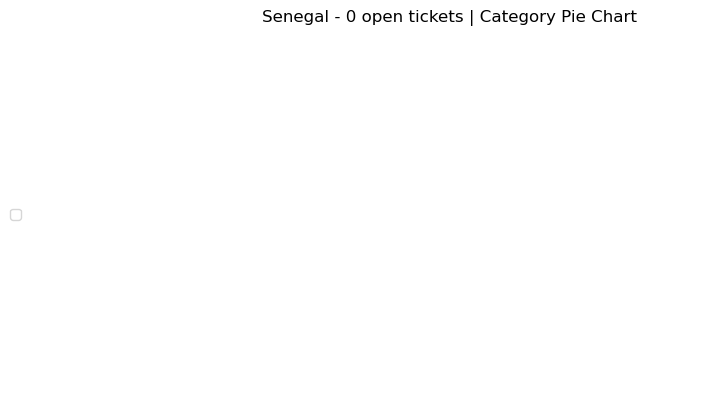

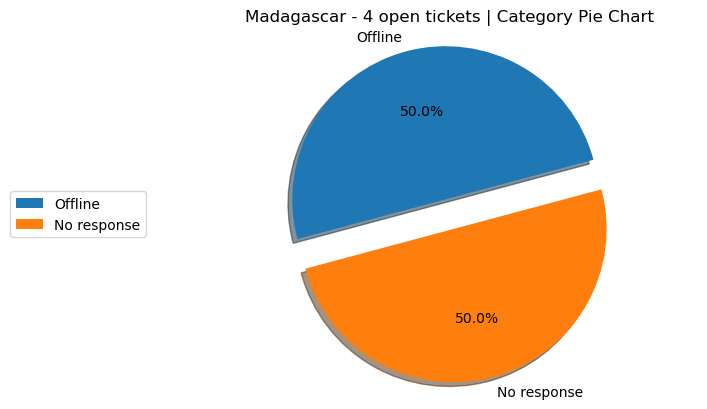

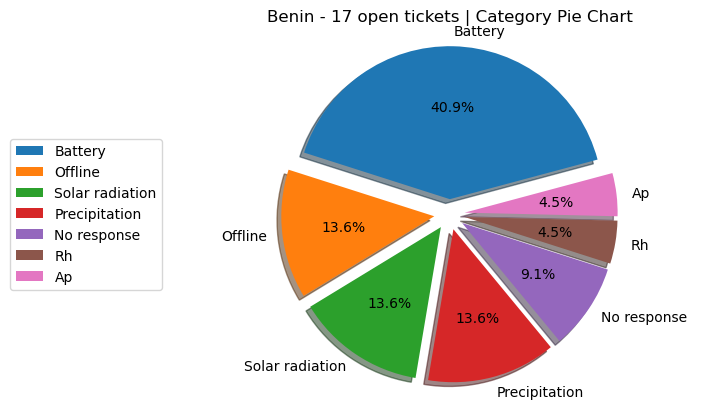

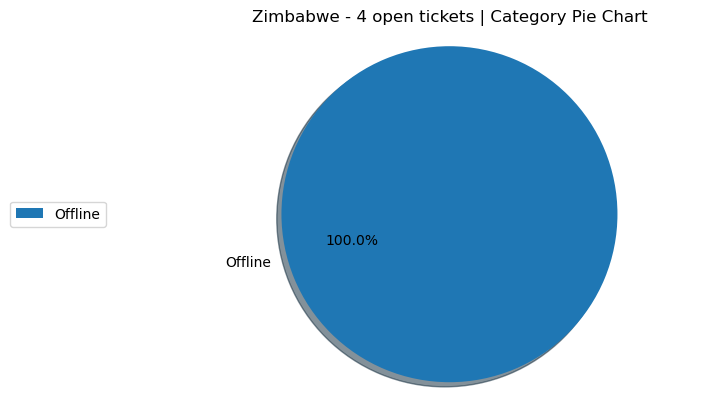

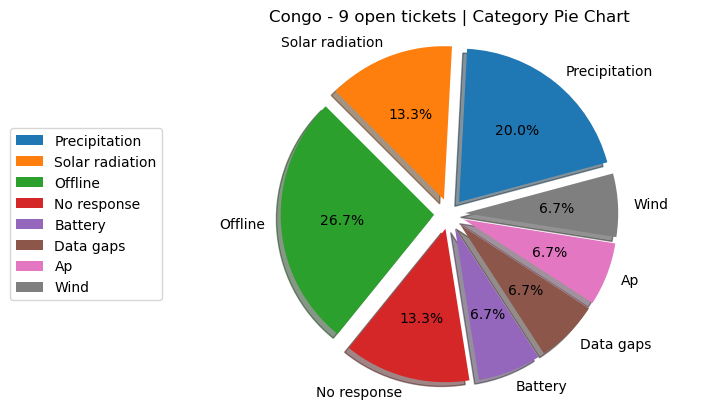

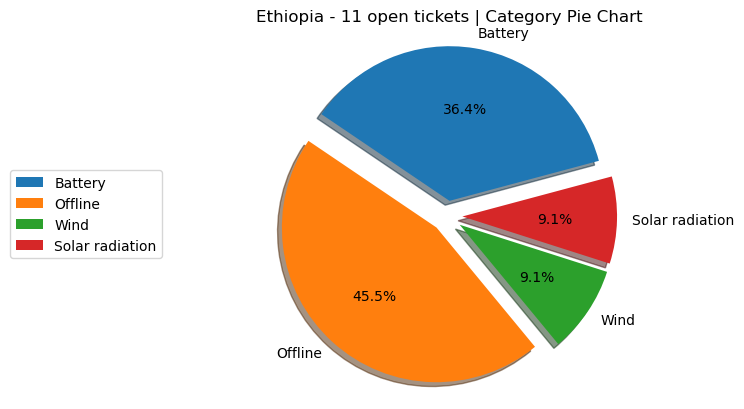

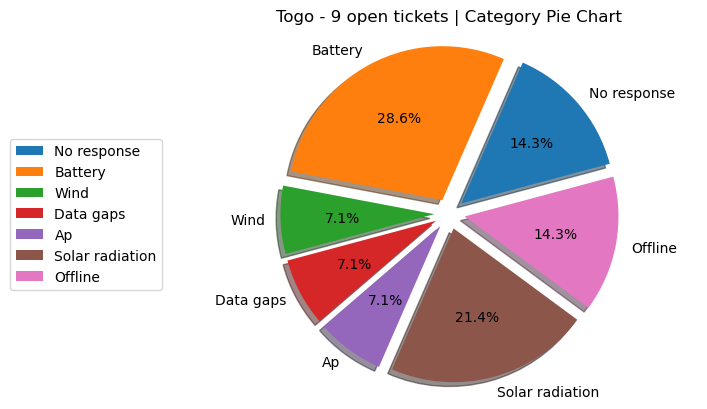

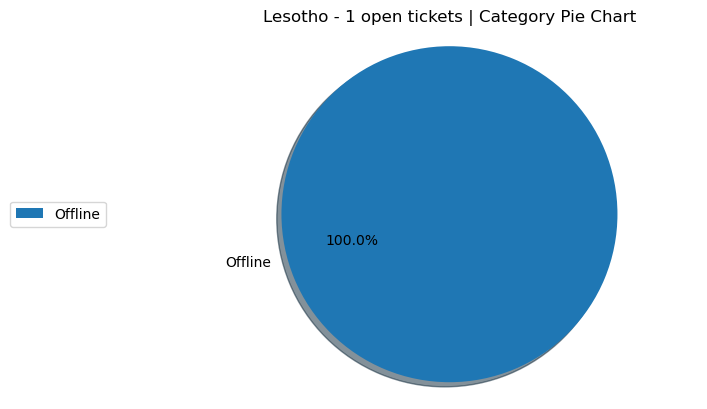

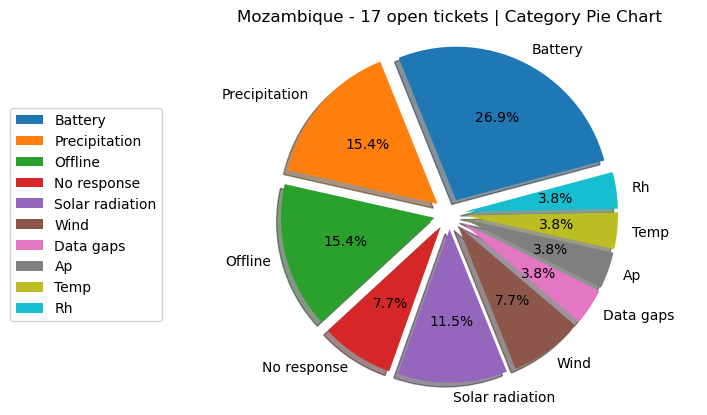

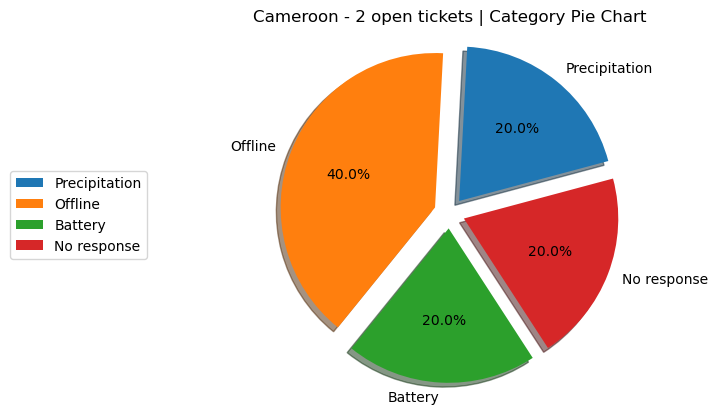

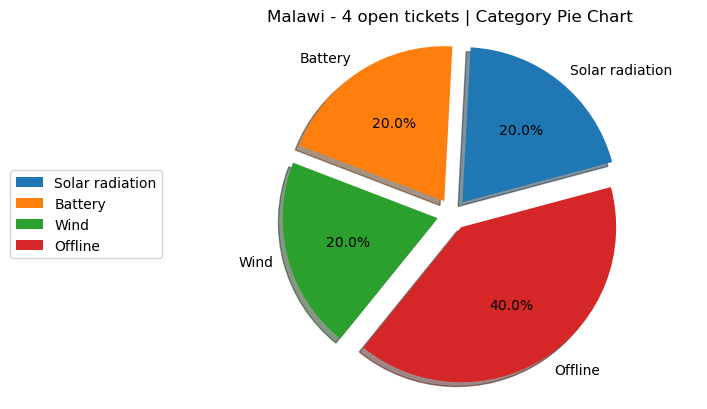

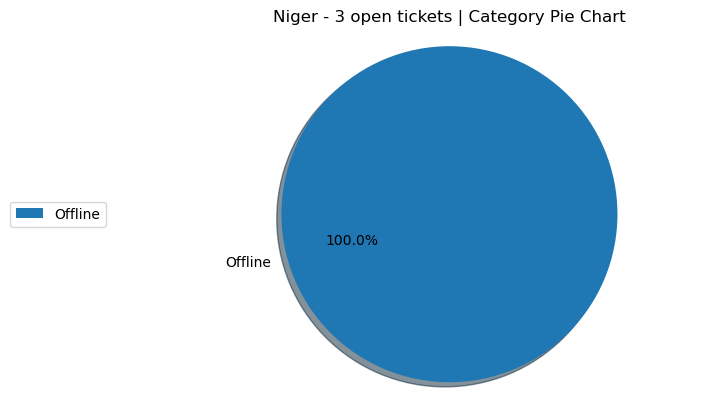

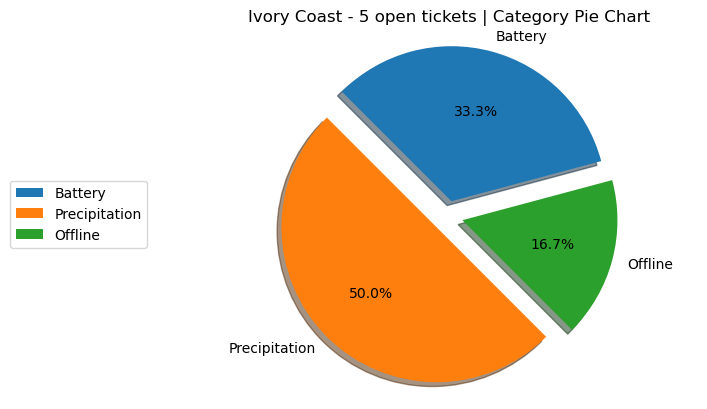

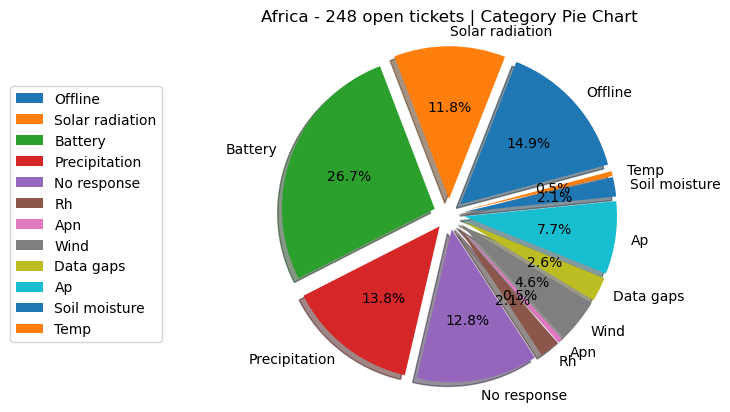

In [14]:
# DOMINANT ISSUES - PLOTS

ea_opened # all tickets opened this year. Some may have been closed. Refer to upper sections
open_tickets # All currently opened tickets in East Africa


for j in range (25): # we do 6 loops; 6 countries and for East Africa - ie.Kenya, Uganda, Tanzania, Rwanda, Ethiopia,Malawi East Africa 
    count = {}
    count_ = {}
    count_3 = {}
    #problem: clogged, data gaps, sensor failure, communication_issue
    
    if j < 24: # the first 5 loops for countries
        # Individual Country
        i = ea_countries[j]
        
        n = open_tickets[open_tickets.Country == i].Country.count() # Counts the number of open tickets in the country
        
        for item in open_tickets[open_tickets.Country == i].Timeseries_variables:
             count[item.lower()] = count.get(item.lower(),0) + 1
    else: # j = 5 (last loop)
        # the last loop is for all East Africa
        # All East Africa Tickets
        n = open_tickets.Country.count() 
        i = "Africa"
        for item in open_tickets.Timeseries_variables:
             count[item.lower()] = count.get(item.lower(),0) + 1
        
    for item in count: 
        count_[item] = count_.get(item,0) + 1

    issues = 'wind','battery/offline','precipitation','radiation', 'soil moisture', 'no response','data gaps'
    others = 'rh','ap','apn','temp','pressure','offline'
    
   #---------- 
    
    #FIT DATA

    issues = ['wind','battery','precipitation','solar radiation', 'soil moisture', 'no response','data gaps',
              'rh',"apn",'ap','temp','ap','rh','ap','offline']

    probe_issue = ['win','batt','preci','radi','soil','respon','gap',
                   'rh','apn','ap','temp','press','humi','atmosphe','off']

    # The next lines are commented since they are no longer useful, but could be used in future. 
    # my_label are is used to categorize items on data. I opted to do this dynamically coz some some items had zero entries. 
    # test_data is hardy when testing the code. 
    #------------------------------------------------------------------
    #my_labels = ['Wind', 'Battery', 'Precipitation', 'Solar Radiation', 
    #            'Soil Moisture', 'No Response', 'Data Gaps', 'Others']
    #test_data =  "pressure",'battery/no response','ap','apn','atmospheric pressure'
    #test_data = 'Pressure','Wind','wind','precipitation','rh','rh','wind','battery/offline','wind','battery/offline','precipitation','radiation', 'soil moisture', 'radiation','radiation','radiation','no response','data gaps'
    #--------------------------------------------------------------------
    
    test_data = count
    test_data =[i.lower() for i in test_data]
    

    clean_data = []

    for t in test_data:
        for p in probe_issue:

            if p in t:
                clean_data.append(issues[probe_issue.index(p)])
                if p == 'apn': # avoids apn being counted as ap. NOTE: The order of probe_issue and issues must not be changed
                    break  
                if p == "press":
                    break
            else:
                pass

    # at this stage we have clean_data   
    
    # The next commmented lines were used during testing. They may be useful for future improvement
    #---------------------------------------------------
    #     counter = {i: clean_data.count(i) for i in issues}
    #     counter_others = {i: clean_data.count(i) for i in issues}

    #     t_summary = {i: clean_data.count(i) for i in clean_data if i not in clean_data}
    #     counter['others'] = sum([value for value in counter_others.values()])
    #     tickets_summary = x.drop(['rh','ap ','apn','temp','pressure'],axis = 0)
    #----------------------------------------------------


    # we create a dictionary with counts of the number of occurances for each ticket issue.
    # then convert it to a dataframe
    counter ={} 
    for item in clean_data: 
        counter[item.lower()] = counter.get(item.lower(),0) + 1
    
    y = pd.DataFrame(counter,index = [0])
    x = y.T
    x.columns = ["Freq"] 
    x.head()
    x.index.name = "Ticket"
    x['Percent']= round((x['Freq']*100/x['Freq'].sum()),2)
    z = x[~(x == 0).all(axis=1)]
   
    my_labels = z.index.tolist() # we pick labels dynamically, changed the earier version where we had labels hard coded
    
    # Now we plot the graph
    import matplotlib.pyplot as plt
    import numpy as np

    %matplotlib inline
    my_data = z['Freq']
    label = []
    for l in my_labels: 
        l = l.capitalize()
        label.append(l)
    
    my_explode = [] # my _explode must be the same length as dataset.
    for k in range(len(my_data)):
         my_explode.append(0.1)
            
    plt.pie(my_data,labels = label,autopct = '%1.1f%%',startangle=15,shadow = True, explode = my_explode)
    plt.title(f'{i} - {n} open tickets | Category Pie Chart')
    plt.legend(loc = 'center left',bbox_to_anchor = (-0.4,0.5))
    plt.axis('equal')
    plt.show()

In [ ]:
#TIME SERIES GRAPH: Tickets Opened by WEEK :  ONGOING 

import datetime
df_open = ea_opened
df_close = ea_closed
df_open["week_no"] = df_open['Issue_date'].dt.week # creates a column with week number
df_close["week_no"] = df_close['Issue_date'].dt.week


t = pd.DataFrame()

for country in ea_countries: 
    c_dataset = df_open[df_open.Country == country]
    t[f"{country} Opened"] = c_dataset.groupby("week_no").week_no.count()
    c_dataset = df_close[df_close.Country == country]
    t[f"{country} Closed"] = c_dataset.groupby("week_no").week_no.count()
t = t.fillna(0)
#t.astype('int') # Convert all elements to integer

# for country in ea_countries: 
#     c_dataset = df_close[df_close.Country == country]
#     t[f"{country} close"] = c_dataset.groupby("week_no").week_no.count()
t = t.fillna(0)
m = t.astype('int') # Convert all elements to integer
#t["EA"] = pd.DataFrame(df.groupby("week_no").week_no.count())
#t.astype('int') # Convert all elements to integer
m.dtypes
m
plt = m.plot.bar()

#plt.show()
# open_series = x.astype('int')# converts the entire dataframe to integer
# open_series

# # PLOT 1: Closed tickets vs Opened Tickets, By COUNTRY
# import matplotlib.pyplot as plt
# %matplotlib inline

# for i in ea_countries:
#     x = pd.DataFrame()
#     x["Opened Tickets"] = open_series[i]
#     x["Closed Tickets"] = closed_series[i]
#     x = x.drop("Total") 
    
#     plt = x.plot.bar()
#     plt.legend(loc = 'right',bbox_to_anchor = (-0.2,0.5))
#     plt.set_ylabel('Number of Tickets')
#     plt.set_title(f"{i} : Monthly Tickets")

# # Totals for East Africa
# x = pd.DataFrame()
# x["Opened Tickets"] = open_series.iloc[:,0]
# x["Closed Tickets"] = closed_series.iloc[:,0]
# x = x.drop("Total")
# plt = x.plot.bar()
# plt.legend(loc = 'right',bbox_to_anchor = (-0.2,0.5))
# plt.set_ylabel('Number of Tickets')
# plt.set_title("East Africa: Monthly Tickets")




In [51]:
#LIST OF OPEN TICKETS per country

### We want to show the site name for each ticket.
### we therefore need to merge 2 databases; open_tickets and stations.
### here we use left join, then select the columns we want to display
open_tickets # All currently opened tickets in East Africa
stations


# print(open_tickets.columns)
# print(stations.columns)

ea_open_tickets = pd.merge(open_tickets,stations,how='left',left_on=['Station_ID'],right_on=['id'])
# print(ea_open_tickets)


ea_open_tickets['days_open'] = pd.to_datetime("today")-ea_open_tickets.Issue_date # timedelta
ea_open_tickets.days_open = ea_open_tickets.days_open.dt.days # From timedelta we pick only the days. 

ea_open_tickets = ea_open_tickets[["id","Country","name","latitude","longitude","Assigned_to","Timeseries_variables","description_of_the_problem",'days_open']]
ea_open_tickets.columns = ['ID', 'Country',"Name","Lat","Long","Assigned to","Timeseries Variables","Problem Description","Days Open"]

# Change the next line of code to filter another country
## ea_open_tickets.query("Country == 'Ethiopia'") # Lists Ethiopia tickets
## ea_open_tickets.query("Country == 'Kenya'") # Lists Kenya tickets
# *********************************************
select_country = ea_open_tickets.query("Country == 'Ivory Coast'")
# *********************************************
#select_country = ea_open_tickets[ea_open_tickets.Country == "Ethiopia"]#reset_index() 

select_country = select_country.sort_values(by=['Days Open'],ascending=[False])
select_country.reset_index(drop=True, inplace=True)
select_country.index = select_country.index + 1
select_country


,ID,Country,Name,Lat,Long,Assigned to,Timeseries Variables,Problem Description,Days Open
1,TA00724,Ivory Coast,"Soubre, Forest tree nursery",5.500418,-6.568501,Kwame,battery issue,data gaps,746.0
2,TA00723,Ivory Coast,"Yamoussoukro, school of Agronomy",6.873281,-5.237501,Kwame,Precipitation,The station might be clogged,682.0
3,TA00722,Ivory Coast,Subiakro,6.700611,-5.265366,Kwame,Battery issue,data gaps and now offline,301.0
4,TA00675,Ivory Coast,Cote D'Ivoire Meteo Office,5.258791,-3.935086,Kwame,precipitation and battery issue,looks clogged,297.0
5,TA00721,Ivory Coast,IITA Divo,5.764023,-5.227729,Ekeke,precipitation & Offline,looks clogged,NaN


In [ ]:
weekno

In [ ]:
import pandas as pd 
  
# creating a dictionary containing a date
dict = {'Date':["2015-06-17"]}
  
# converting the dictionary to a dataframe
df = pd.DataFrame.from_dict(dict)
  
# converting the date to the required format
df['Date'] = pd.to_datetime(df['Date'], errors ='coerce')
df.astype('int64').dtypes
  
# extracting the week from the date
weekNumber = df['Date'].dt.week
  
print(weekNumber)

In [ ]:
df

In [ ]:
t = pd.DataFrame()

In [ ]:
import pandas as pd

url = "https://datahub.tahmo.org/custom/stations/status?output=csv"
df = pd.read_csv(url)

df.head()

In [ ]:
display(open_tickets.head(1))
#open_tickets.head(1)
stations.head(1)

In [ ]:
ea_open_tickets = pd.merge(open_tickets,stations,how='left',left_on=['Station_id'],right_on=['id'])
x = ea_open_tickets
x['days_open'] = pd.to_datetime("today")-x.Issue_date# timedelta
x.days_open = x.days_open.dt.days

In [ ]:
x.dtypes

In [ ]:
x.days_open.dt.days

In [ ]:
import pandas as pd
import numpy as np

np.random.seed(24)
df = pd.DataFrame({'A': np.linspace(1, 10, 10)})

df = pd.concat([df, pd.DataFrame(np.random.randn(10, 4), columns=list('BCDE'))],
               axis=1)
df.iloc[0, 2] = np.nan

def highlight_greaterthan(s,column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] >= 1
    return ['background-color: red' if is_max.any() else '' for v in is_max]

def highlight_greaterthan_1(s):
    if s.B > 1.0:
        return ['background-color: yellow']*5
    else:
        return ['background-color: white']*5


df.style.apply(highlight_greaterthan_1, axis=1)

In [ ]:
east_africa = ['KE','UG','RW','TZ','ET']
stations[stations.country_code.isin(['KE'])]

In [ ]:
stations.head(2)